# Graph showing (ET:Precip ratio vs Groundwater trends) for all sites.

In [11]:
import os
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from scipy.stats import spearmanr # Using for Spearman Rank Correlation


# Skip next 3 code chunks they are for data download/raster creation

## API to download precipitation data

In [ ]:

base_url = "https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access"
years = range(1996, 2026)

out_dir = "gpcp_data"
os.makedirs(out_dir, exist_ok=True)

for year in years:
    url = f"{base_url}/{year}/"
    r = requests.get(url)
    r.raise_for_status()

    for line in r.text.split():
        if ".nc" in line:
            fname = line.split('"')[1]
            file_url = url + fname
            out_path = os.path.join(out_dir, fname)

            if not os.path.exists(out_path):
                print("Downloading", fname)
                data = requests.get(file_url)
                open(out_path, "wb").write(data.content)

## Inspect Precipitation data

In [ ]:
# Takes 2:40 mins to run

import xarray as xr
import glob

# Read in folders from cyberduck
gpcp_data_dir = "/capstone/aridgw/data/gpcp_data/"

files = sorted(glob.glob(gpcp_data_dir + "*.nc"))
print(len(files), "files found")

# Open them with xarray, combine them
ds = xr.open_mfdataset(files, combine="by_coords")
ds


In [ ]:
# Check data vairables
ds.data_vars


## Compute a multi-year normal (mean) and create raster

In [ ]:
# Takes 2:15 mins to run

# Compute a multi-year normal (mean)
precip_normal = ds["precip"].mean(dim="time")
precip_normal

# Save as a raster (GeoTIFF)
import rioxarray

precip_normal = precip_normal.rio.write_crs("EPSG:4326")
precip_normal.rio.to_raster("gpcp_precip_normal.tif")


# Start here to create plot

## Combining ET and Groundwater data for all sites

In [4]:
# Read in all ET and GW data for all sites

# San Simon Valley
et_gw_merged_san_simon_valley = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_san_simon_valley.csv"
et_gw_merged_san_simon_valley = pd.read_csv(et_gw_merged_san_simon_valley)

# Butler Valley
et_gw_merged_butler_valley = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_butler_valley.csv"
et_gw_merged_butler_valley = pd.read_csv(et_gw_merged_butler_valley)

# McMulllen Valley
et_gw_merged_mcmulllen_valley = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_mcmulllen_valley.csv"
et_gw_merged_mcmulllen_valley = pd.read_csv(et_gw_merged_mcmulllen_valley)

# Hualapai Valley Basin
et_gw_merged_hualapai_valley_basin = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_hualapai_valley_basin.csv"
et_gw_merged_hualapai_valley_basin = pd.read_csv(et_gw_merged_hualapai_valley_basin)

# Southern Willcox Basin
et_gw_merged_southern_willcox_basin = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_southern_willcox_basin.csv"
et_gw_merged_southern_willcox_basin = pd.read_csv(et_gw_merged_southern_willcox_basin)

# Nevada (Amargosa)
et_gw_merged_nevada_amargosa = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_nevada_amargosa.csv"
et_gw_merged_nevada_amargosa = pd.read_csv(et_gw_merged_nevada_amargosa)

# Arizona (Willcox Basin)
et_gw_merged_arizona_willcox_basin = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_arizona_willcox_basin.csv"
et_gw_merged_arizona_willcox_basin = pd.read_csv(et_gw_merged_arizona_willcox_basin)

# Cuyama
et_gw_merged_cuyama = "/capstone/aridgw/data/merged_timeseries_1km/et_gw_merged_cuyama.csv"
et_gw_merged_cuyama = pd.read_csv(et_gw_merged_cuyama)

In [5]:
# Concatenate data
et_gw_merged_all_sites = pd.concat([
    et_gw_merged_san_simon_valley,
    et_gw_merged_butler_valley,
    et_gw_merged_mcmulllen_valley,
    et_gw_merged_hualapai_valley_basin,
    et_gw_merged_southern_willcox_basin,
    et_gw_merged_nevada_amargosa,
    et_gw_merged_arizona_willcox_basin,
    et_gw_merged_cuyama
], ignore_index=True)


## Extract precip values for each well site

In [6]:

et_gw_merged_all_sites = et_gw_merged_all_sites.copy()

# convert longitudes from -180–180 to 0–360
et_gw_merged_all_sites["lon_360"] = np.where(
    et_gw_merged_all_sites["longitude"] < 0,
    et_gw_merged_all_sites["longitude"] + 360,
    et_gw_merged_all_sites["longitude"]
)

with rasterio.open("/capstone/aridgw/data/gpcp_precip_normal.tif") as src:
    coords = list(zip(
        et_gw_merged_all_sites["lon_360"],
        et_gw_merged_all_sites["latitude"]
    ))
    values = [v[0] for v in src.sample(coords)]

et_gw_merged_all_sites["gpcp_precip_normal"] = values


In [7]:
et_gw_merged_all_sites.head()

,MEDS_ID,MEDS_ANNUAL_MEDIAN_ROW,YEAR,WaterLevel_m,WaterLevelElev_masl,Title Location,Lat,Lon,tile_id,year,location,latitude,longitude,tile,mean_ET_mm_yr,buffer_radius_m,lon_360,gpcp_precip_normal
0,17,574,2003,67.60464,NaN,San Simon Valley,32.171194,-109.157837,h08v05,2003.0,San Simon Valley,32.171194,-109.157837,h08v05,170.530762,1000.0,250.842163,0.900574
1,17,575,2004,66.72072,NaN,San Simon Valley,32.171194,-109.157837,h08v05,2004.0,San Simon Valley,32.171194,-109.157837,h08v05,230.538467,1000.0,250.842163,0.900574
2,17,576,2005,71.56704,NaN,San Simon Valley,32.171194,-109.157837,h08v05,2005.0,San Simon Valley,32.171194,-109.157837,h08v05,239.988449,1000.0,250.842163,0.900574
3,17,577,2007,67.45224,NaN,San Simon Valley,32.171194,-109.157837,h08v05,2007.0,San Simon Valley,32.171194,-109.157837,h08v05,276.661530,1000.0,250.842163,0.900574
4,17,578,2008,82.02168,NaN,San Simon Valley,32.171194,-109.157837,h08v05,2008.0,San Simon Valley,32.171194,-109.157837,h08v05,278.073059,1000.0,250.842163,0.900574


## Calculate groundwater trend per site and ET/precip ratio per site

In [8]:
# Calculate groundwater trend per site

df = et_gw_merged_all_sites.copy()

def calc_trend(group):
    # drop missing values
    g = group.dropna(subset=["YEAR", "WaterLevel_m"])
    if len(g) < 2:
        return np.nan
    
    # slope (m/year)
    slope = np.polyfit(g["YEAR"], g["WaterLevel_m"], 1)[0]
    return slope

gw_trends = df.groupby("location").apply(calc_trend).reset_index()
gw_trends.columns = ["location", "gw_trend_m_per_yr"]



# Compute ET : Precip ratio per site

climate = df.groupby("location").agg(
    mean_et=("mean_ET_mm_yr", "mean"),
    mean_precip=("gpcp_precip_normal", "mean")
).reset_index()

climate["et_precip_ratio"] = climate["mean_et"] / climate["mean_precip"]

# Merge them
site_summary = gw_trends.merge(climate, on="location")
site_summary



/tmp/ipykernel_435599/1786230832.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gw_trends = df.groupby("location").apply(calc_trend).reset_index()


,location,gw_trend_m_per_yr,mean_et,mean_precip,et_precip_ratio
0,Arizona (Willcox Basin),2.460569,257.231247,0.892019,288.369549
1,Butler Valley,1.909301,162.346309,0.580982,279.434389
2,Cuyama,0.427477,184.115132,0.970066,189.796451
3,Hualapai Valley Basin,1.564896,115.447110,0.678500,170.150525
4,McMulllen Valley,0.428793,91.588407,0.708217,129.322482
5,Nevada (Amargosa),0.281753,64.273913,0.679086,94.647682
6,San Simon Valley,2.353814,249.395189,0.900574,276.929027
7,Southern Willcox Basin,0.449900,173.828178,0.913223,190.345836


## Visualize data for all 8 sites

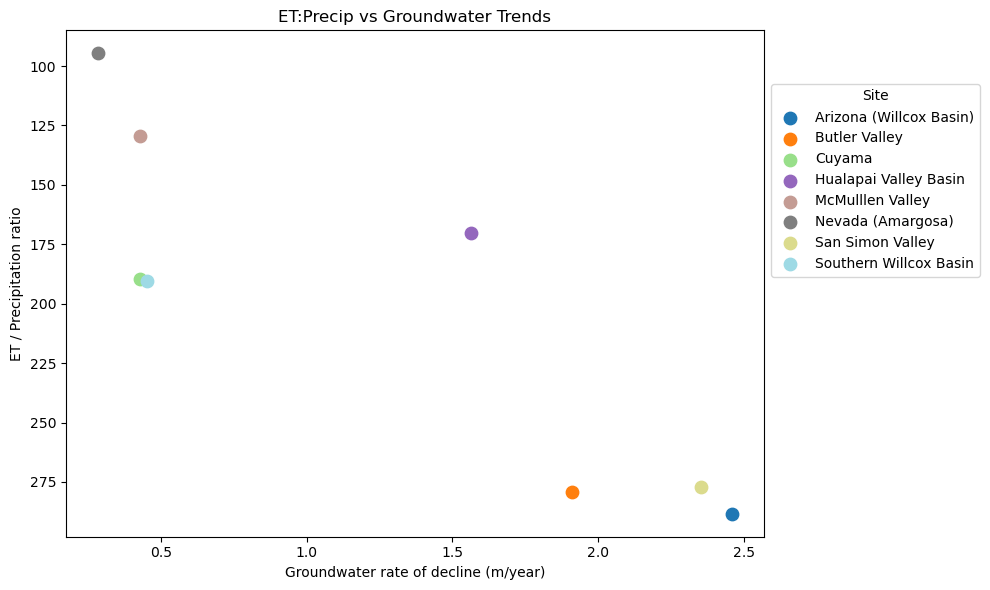

In [9]:
# Get unique sites
sites = site_summary["location"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(sites)))  # assign a color for each site

plt.figure(figsize=(10, 6))

# Scatter points colored by site
for site, color in zip(sites, colors):
    subset = site_summary[site_summary["location"] == site]
    plt.scatter(subset["gw_trend_m_per_yr"],
                subset["et_precip_ratio"],
                label=site,
                color=color,
                s=80)

# # Label each point with its site
# for i, row in site_summary.iterrows():
#     plt.text(row["gw_trend_m_per_yr"] + 0.05,
#              row["et_precip_ratio"],
#              row["location"],   # updated column name
#              fontsize=9)

plt.xlabel("Groundwater rate of decline (m/year)")
plt.ylabel("ET / Precipitation ratio")
plt.title("ET:Precip vs Groundwater Trends")
plt.legend(title="Site", loc='lower left', bbox_to_anchor=(1, .5))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




# Spearman Correlation 

In [12]:
# Variables to test against gw_trend
variables = ['mean_et', 'mean_precip', 'et_precip_ratio']

print("Spearman Rank Correlations with Groundwater Trend:\n")
for var in variables:
    rho, p_value = spearmanr(site_summary['gw_trend_m_per_yr'], 
                             site_summary[var])
    print(f"{var:20s}: rho = {rho:6.3f}, p = {p_value:.3f}")

Spearman Rank Correlations with Groundwater Trend:

mean_et             : rho =  0.690, p = 0.058
mean_precip         : rho = -0.119, p = 0.779
et_precip_ratio     : rho =  0.857, p = 0.007


In [15]:
def calc_spearman_per_site(group):
    g = group.dropna(subset=["WaterLevel_m", "mean_ET_mm_yr"])
    if len(g) < 3:
        return pd.Series({'rho': np.nan, 'p_value': np.nan})
    
    rho, p = spearmanr(g["WaterLevel_m"], g["mean_ET_mm_yr"])
    return pd.Series({'rho': rho, 'p_value': p})

site_correlations = df.groupby("location").apply(calc_spearman_per_site)

site_correlations

/tmp/ipykernel_435599/840617240.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  site_correlations = df.groupby("location").apply(calc_spearman_per_site)


,rho,p_value
location,,
Arizona (Willcox Basin),0.735294,0.001172
Butler Valley,0.826471,0.000079
Cuyama,-0.226316,0.351500
Hualapai Valley Basin,0.783333,0.012520
McMulllen Valley,0.017391,0.935715
Nevada (Amargosa),-0.326087,0.128887
San Simon Valley,0.279720,0.378569
Southern Willcox Basin,0.600000,0.066688


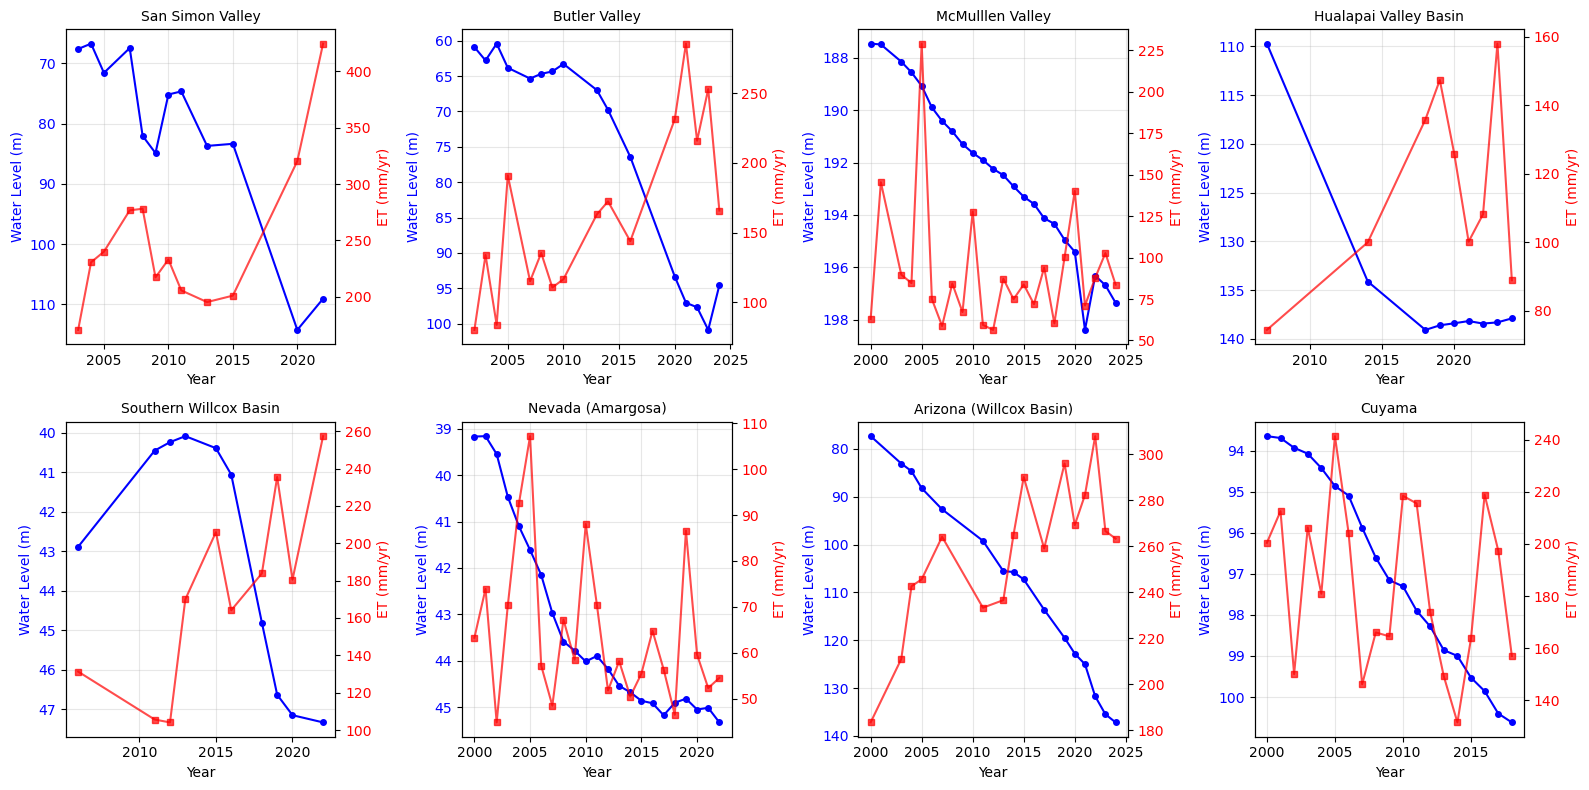

In [18]:

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

sites = et_gw_merged_all_sites['location'].unique()

for i, site in enumerate(sites):
    ax1 = axes[i]
    site_data = et_gw_merged_all_sites[et_gw_merged_all_sites['location'] == site].sort_values('YEAR')    
    # Water level
    ax1.plot(site_data['YEAR'], site_data['WaterLevel_m'], 
             'b-o', label='Water Level', markersize=4)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Water Level (m)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.invert_yaxis()  # Flip y-axis
    
    # ET on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(site_data['YEAR'], site_data['mean_ET_mm_yr'], 
             'r-s', label='ET', markersize=4, alpha=0.7)
    ax2.set_ylabel('ET (mm/yr)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_title(site, fontsize=10)
    ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- Water levels show consistent long-term decline at most sites (San Simon, Butler, Arizona Willcox, Cuyama)
- ET shows interannual variability but no obvious trend
- High ET years don't consistently correspond to bigger water level drops
- This suggests pumping is the primary driver, not ET changes
